In [16]:
import pandas as pd
import unicodedata


# Función para quitar acentos y convertir a mayúsculas
def normalizar(texto):
    if pd.isnull(texto):
        return ""
    return unicodedata.normalize("NFKD", texto).encode("ASCII", "ignore").decode("utf-8").upper().strip()


# Cargar archivos
casos = pd.read_csv("../data/case_data_base.csv", parse_dates=["date"])
clima = pd.read_csv("../data/datos_meteorologicos.csv", parse_dates=["fecha"])

# Normalizar los nombres para poder hacer match
casos["name"] = casos["name"].apply(normalizar)
clima["departamento"] = clima["departamento"].apply(normalizar)

# Columnas nuevas
casos["temp_promedio_7d"] = None
casos["precip_promedio_7d"] = None



In [17]:
# Iterar sobre cada fila de casos
for idx, row in casos.iterrows():
    fecha_actual = row["date"]
    depto = row["name"]


    def get_departamentos(depto):
        if depto == 'CHACO':
            return ['BOQUERON', 'PTE HAYES', 'ALTO PARAGUAY']
        elif depto == 'METROPOLITANO':
            return ['CENTRAL']
        elif depto == 'CENTRO EST':
            return ['CORDILLERA', 'CAAGUAZU', 'GUAIRA', 'CAAZAPA', 'ALTO PARANA']
        elif depto == 'CENTRO NORTE':
            return ['CONCEPCION', 'AMAMBAY', 'SAN PEDRO', 'CANINDEYU']
        elif depto == 'CENTRO SUR':
            return ['MISIONES', 'ITAPUA', 'PARAGUARI', 'NEEMBUCU']
        elif depto == 'PARAGUAY':
            return None
        else:
            return [depto]


    dptos = get_departamentos(depto)


    def filtrar_clima(inicio, fin):
        if dptos is None:
            return clima[(clima["fecha"] >= inicio) & (clima["fecha"] < fin)]
        else:
            return clima[(clima["departamento"].isin(dptos)) &
                         (clima["fecha"] >= inicio) & (clima["fecha"] < fin)]


    # Ventana 1: últimos 7 días
    clima_7d = filtrar_clima(fecha_actual - pd.Timedelta(days=7), fecha_actual)

    # Ventana 2: últimos 14 días
    clima_14d = filtrar_clima(fecha_actual - pd.Timedelta(days=14), fecha_actual)

    # Asignación de valores si hay datos
    if not clima_7d.empty:
        casos.at[idx, "temp_promedio_7d"] = clima_7d["temperatura"].mean()
        casos.at[idx, "precip_promedio_7d"] = clima_7d["precipitaciones"].mean()

    if not clima_14d.empty:
        casos.at[idx, "temp_promedio_14d"] = clima_14d["temperatura"].mean()
        casos.at[idx, "precip_promedio_14d"] = clima_14d["precipitaciones"].mean()


# Guardar el resultado



In [18]:
registros_sin_temperatura = casos[casos["temp_promedio_14d"].isna()]
print(registros_sin_temperatura['name'].unique())

[]


In [19]:
casos

,date,name,level,disease,classification,i_cases,Population,incidence,temp_promedio_7d,precip_promedio_7d,temp_promedio_14d,precip_promedio_14d
0,2019-01-05,ALTO PARANA,Department,DENGUE,CONFIRMADO,0,864920.130752,0.000000,28.975,3.075,28.975000,3.075000
1,2019-01-05,ALTO PARANA,Department,DENGUE,PROBABLE,0,864920.130752,0.000000,28.975,3.075,28.975000,3.075000
2,2019-01-05,ALTO PARANA,Department,DENGUE,SOSPECHOSO,11,864920.130752,1.271794,28.975,3.075,28.975000,3.075000
3,2019-01-05,ALTO PARANA,Department,DENGUE,TOTAL,11,864920.130752,1.271794,28.975,3.075,28.975000,3.075000
4,2019-01-05,AMAMBAY,Department,DENGUE,CONFIRMADO,0,179773.138253,0.000000,26.15,3.675,26.150000,3.675000
...,...,...,...,...,...,...,...,...,...,...,...,...
63875,2023-09-16,PTE HAYES,Department,DENGUE,TOTAL,6,134879.540262,4.448414,21.214286,3.685714,22.114286,7.735714
63876,2023-09-16,SAN PEDRO,Department,ARBOVIROSIS,CONFIRMADO,0,450802.189324,0.000000,21.885714,2.542857,22.978571,5.807143
63877,2023-09-16,SAN PEDRO,Department,ARBOVIROSIS,PROBABLE,0,450802.189324,0.000000,21.885714,2.542857,22.978571,5.807143
63878,2023-09-16,SAN PEDRO,Department,ARBOVIROSIS,SOSPECHOSO,23,450802.189324,5.102016,21.885714,2.542857,22.978571,5.807143


In [20]:
casos.to_csv("../data/case_data_full.csv", index=False)
print("✅ CSV generado: case_data_con_promedios_climaticos.csv")

✅ CSV generado: case_data_con_promedios_climaticos.csv


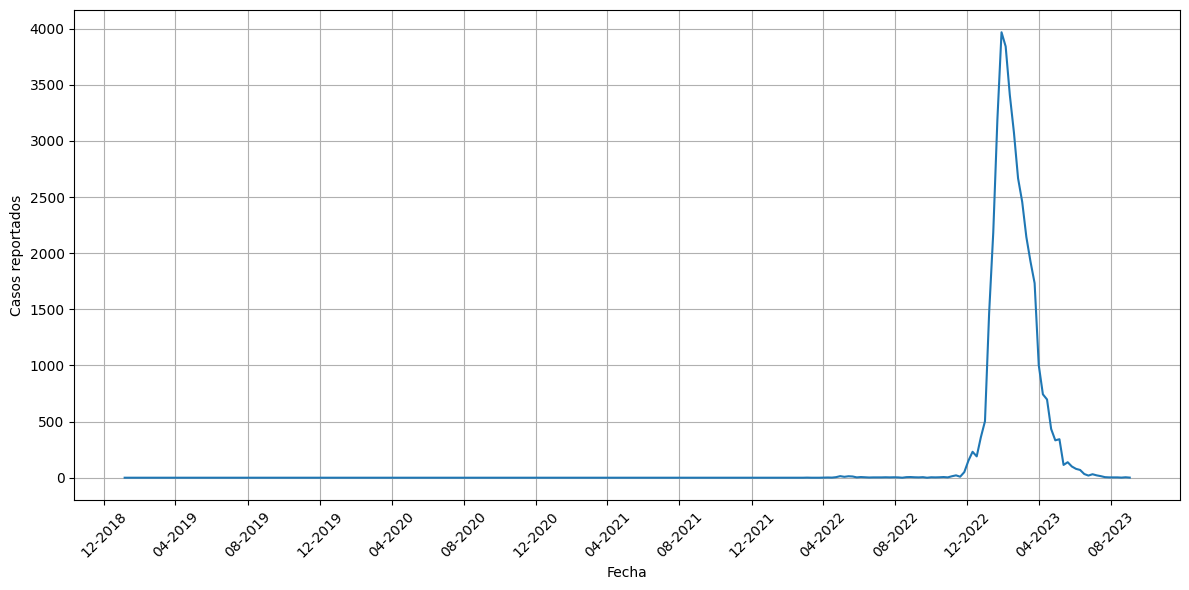

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


dengue = casos[
    (casos['name'] == 'CENTRAL') & (casos['disease'] == 'CHIKUNGUNYA') & (casos['classification'] == 'CONFIRMADO')]

plt.figure(figsize=(12, 6))
plt.plot(dengue["date"], dengue["i_cases"],  linestyle='-')

plt.xlabel("Fecha")
plt.ylabel("Casos reportados")
plt.grid(True)

# Formatear eje X con MM-YYYY
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('distribucion_chiku.png')
plt.show()